# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import random
import datetime
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.linalg import cond
from typing import List

# Matrixlib
import matrixkit.block as blk
from matrixkit import preconditioning as prec
from matrixkit.core import MatrixData, ValueProperties, BlockProperties

# Modellib
import modellib.cnn
import modellib.train
import modellib.evaluate as eval

import modellib.io as io

2024-07-28 00:57:35.649878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 00:57:35.692344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 00:57:35.704512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load original matrices, true block starts and predicted block starts from CNN and SVB Algorithm

In [2]:
# Reading original test matrices 
test_matrices = np.load('data/matrices/test_matrices_64x64_200.npy')

# Reading block start indicators
_, true_blocks = io.read_from_hdf5('data/datasets/test_dataset_64_200.h5')
cnn_blocks = np.load('data/blockstarts/cnn_predictions.npy')
svb_blocks = np.load('data/blockstarts/svb_predictions_max_16.npy')

# Verify Shapes
print(f'Test Matrices Shape: {test_matrices.shape}')
print(f'True Blockstarts Shape: {true_blocks.shape}')
print(f'CNN Predictions Shape: {cnn_blocks.shape}')
print(f'SVB Predictions Shape: {svb_blocks.shape}')

Test Matrices Shape: (200, 64, 64)
True Blockstarts Shape: (200, 64)
CNN Predictions Shape: (200, 64)
SVB Predictions Shape: (200, 64)



# Create Preconditioner from true and predicted block starts
### 1. Generate variants of the original matrix data as inversion targets (i.e. 'A' in 'Ax = b')



In [3]:
A_orig = test_matrices
A_norm = prec.prepare_matrix(A_orig, mapping_type='minmax')
A_flip = prec.prepare_matrix(A_orig, mapping_type='flip')
A_flip_norm = prec.prepare_matrix(A_orig, mapping_type='flip_norm')
A_shift = prec.prepare_matrix(A_orig, mapping_type='shift')
A_shift_norm = prec.prepare_matrix(A_orig, mapping_type='shift_norm')

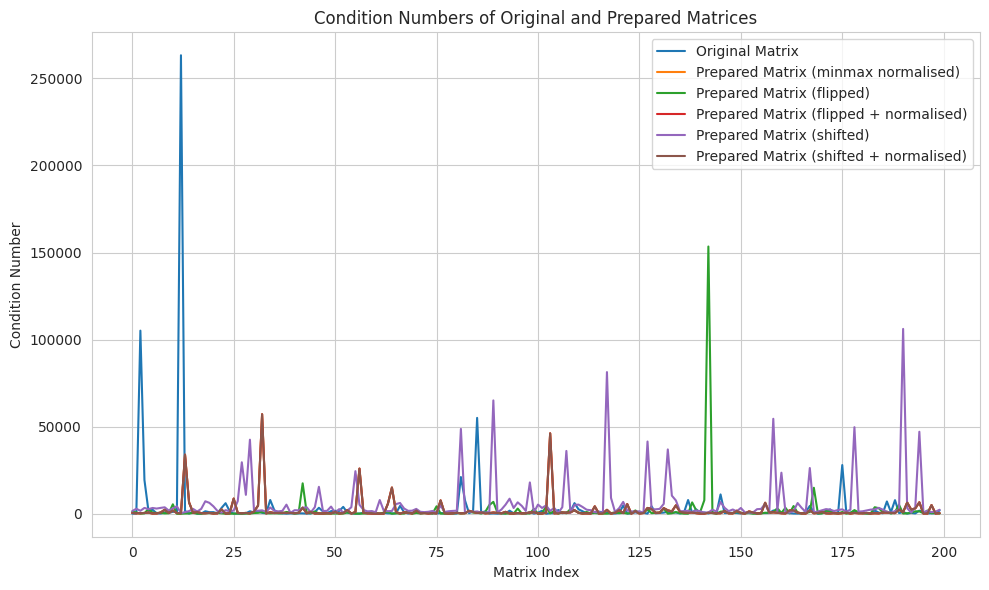

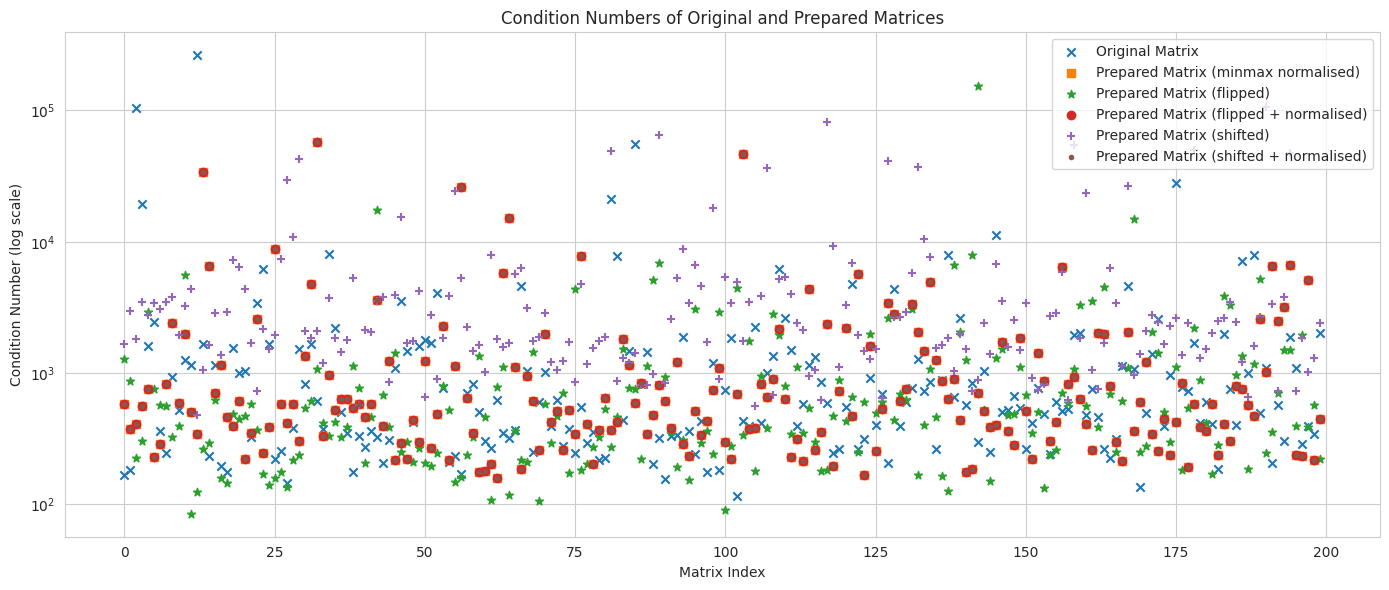

In [9]:
# Calculate condition numbers for each method
def calculate_condition_numbers(matrices):
    return [cond(matrix) for matrix in matrices]

# Calculate condition numbers for each method
cond_orig = calculate_condition_numbers(A_orig)
cond_norm = calculate_condition_numbers(A_norm)
cond_flip = calculate_condition_numbers(A_flip)
cond_flip_norm = calculate_condition_numbers(A_flip_norm)
cond_shift = calculate_condition_numbers(A_shift)
cond_shift_norm = calculate_condition_numbers(A_shift_norm)

# Plot condition numbers
plt.figure(figsize=(10, 6))
plt.plot(cond_orig, label='Original Matrix')
plt.plot(cond_norm, label='Prepared Matrix (minmax normalised)')
plt.plot(cond_flip, label='Prepared Matrix (flipped)')
plt.plot(cond_flip_norm, label='Prepared Matrix (flipped + normalised)')
plt.plot(cond_shift, label='Prepared Matrix (shifted)')
plt.plot(cond_shift_norm, label='Prepared Matrix (shifted + normalised)')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
# plt.yscale('log')  # Added log scale for better visibility
plt.tight_layout()
plt.show()

# Scatterplot 
plt.figure(figsize=(14, 6))
plt.scatter(range(len(cond_orig)), cond_orig, label='Original Matrix', marker='x')
plt.scatter(range(len(cond_norm)), cond_norm, label='Prepared Matrix (minmax normalised)', marker='s')
plt.scatter(range(len(cond_flip)), cond_flip, label='Prepared Matrix (flipped)', marker='*')
plt.scatter(range(len(cond_flip_norm)), cond_flip_norm, label='Prepared Matrix (flipped + normalised)', marker='o')
plt.scatter(range(len(cond_shift)), cond_shift, label='Prepared Matrix (shifted)', marker='+')
plt.scatter(range(len(cond_shift_norm)), cond_shift_norm, label='Prepared Matrix (shifted + normalised)', marker='.')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number (log scale)')
plt.gca().set_yscale('log')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Create a DataFrame for easy plotting and analysis
df = pd.DataFrame({
    'Original': cond_orig,
    'Normalised': cond_norm,
    'Flipped': cond_flip,
    'Flipped + Normalised': cond_flip_norm,
    'Shifted': cond_shift,
    'Shifted + Normalised': cond_shift_norm
})

# Calculate statistics
stats = df.agg(['mean', 'median', 'min', 'max', 'std']).T
stats['improvement'] = (stats['mean'] - stats.loc['Original', 'mean']) / stats.loc['Original', 'mean'] * 100 * -1

# Print summary statistics
print(stats.to_string())

                             mean       median         min            max           std  improvement
Original              3576.480713   586.016479  115.035286  263269.718750  20455.035156    -0.000000
Normalised            1950.931763   566.987305  159.084396   57215.328125   6088.224609    45.451077
Flipped               1845.928467   471.344482   84.779854  153495.859375  10960.286133    48.387016
Flipped + Normalised  1950.931763   566.987305  159.084396   57215.328125   6088.224609    45.451077
Shifted               6144.447266  2098.647949  476.923065  106196.968750  13482.469727   -71.801498
Shifted + Normalised  1950.931763   566.987305  159.084396   57215.328125   6088.224609    45.451077


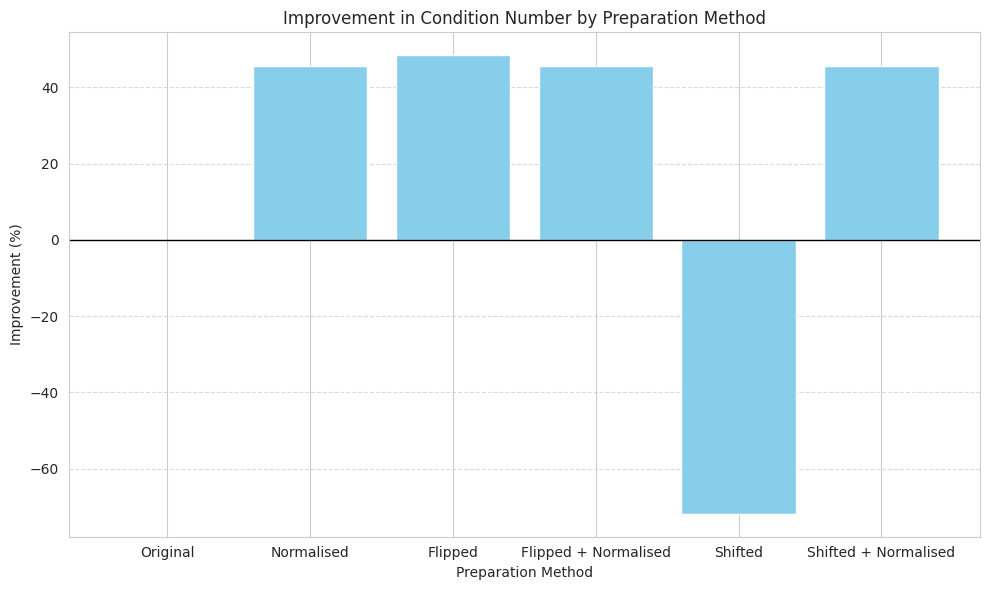

In [13]:
# Plot summary statistics
plt.figure(figsize=(10, 6))
plt.bar(stats.index, stats['improvement'], color='skyblue')
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Preparation Method')
plt.ylabel('Improvement (%)')
plt.title('Improvement in Condition Number by Preparation Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2. Invert Blocks (ensure non-singularity)

In [26]:
# Using True Blockstarts and Matrices with differen preprocessing methods
precs_true = prec.generate_block_jacobi_preconditioner(A_orig, true_blocks)
precs_true_norm = prec.generate_block_jacobi_preconditioner(A_norm, true_blocks)
precs_true_flip = prec.generate_block_jacobi_preconditioner(A_flip, true_blocks)
precs_true_flip_norm = prec.generate_block_jacobi_preconditioner(A_flip_norm, true_blocks)
precs_true_shift_norm = prec.generate_block_jacobi_preconditioner(A_shift_norm, true_blocks)

b = np.ones((test_matrices.shape[0], A_orig.shape[1]))

# Run GMRES Solver:
 ### With and Without Preconditioner from True Block Starts
    - With original Matrices
    - With normalised Matrices
    - With flipped Matrices
    - With flipped and normalised Matrices
    - With shifted Matrices
    - With shifted and normalised Matrices
    

In [23]:
importlib.reload(prec)

<module 'matrixkit.preconditioning' from '/home/moonchild/PycharmProjects/preconditioners/matrixkit/preconditioning.py'>

Solving Original Matrices with No Preconditioner
Solving Original Matrices with Prec from True Block Starts
Solving Original Matrices with Prec from True Block Starts (Normalised)
Solving Original Matrices with Prec from True Block Starts (Flipped)
Solving Original Matrices with Prec from True Block Starts (Flipped + Normalised)
Solving Original Matrices with Prec from True Block Starts (Shifted + Normalised)
Solving Normalised Matrices with No Preconditioner
Solving Normalised Matrices with Prec from True Block Starts
Solving Normalised Matrices with Prec from True Block Starts (Normalised)
Solving Normalised Matrices with Prec from True Block Starts (Flipped)
Solving Normalised Matrices with Prec from True Block Starts (Flipped + Normalised)
Solving Normalised Matrices with Prec from True Block Starts (Shifted + Normalised)
Solving Flipped Matrices with No Preconditioner
Solving Flipped Matrices with Prec from True Block Starts
Solving Flipped Matrices with Prec from True Block Start

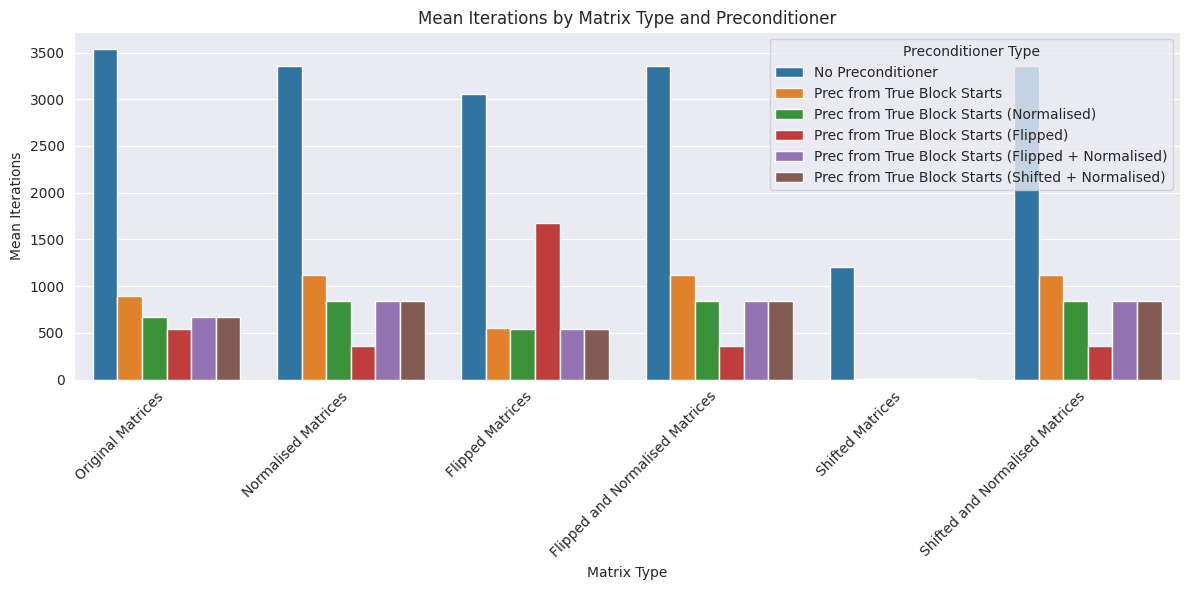

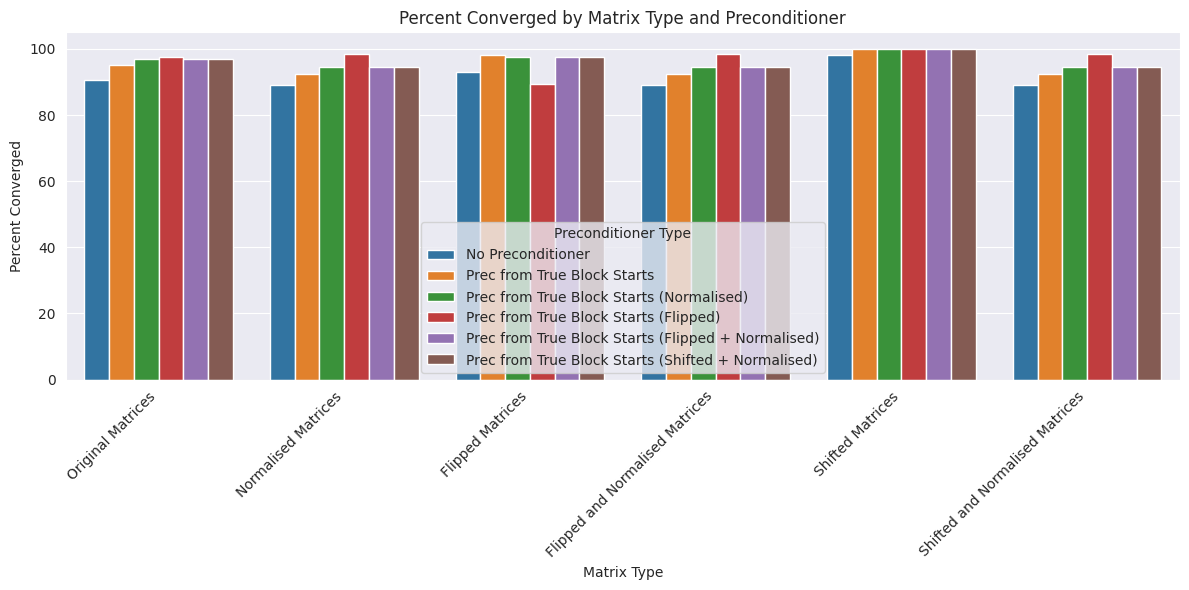

In [28]:
importlib.reload(prec)

input_matrices_list = [
    ('Original Matrices', A_orig),
    ('Normalised Matrices', A_norm),
    ('Flipped Matrices', A_flip),
    ('Flipped and Normalised Matrices', A_flip_norm),
    ('Shifted Matrices', A_shift),
    ('Shifted and Normalised Matrices', A_shift_norm)
]

preconditioners_list = [
    ('No Preconditioner', None),
    ('Prec from True Block Starts', precs_true),
    ('Prec from True Block Starts (Normalised)', precs_true_norm),
    ('Prec from True Block Starts (Flipped)', precs_true_flip),
    ('Prec from True Block Starts (Flipped + Normalised)', precs_true_flip_norm),
    ('Prec from True Block Starts (Shifted + Normalised)', precs_true_shift_norm)
]

results_df = prec.run_gmres_experiments(input_matrices_list, preconditioners_list, b)
prec.print_results_table(results_df)
prec.plot_results(results_df)

## Compare Results

In [29]:
results_df

,Matrix Type,Preconditioner Type,Converged,Total Systems,Percent Converged,Mean Iterations,Median Iterations,Max Iterations,Min Iterations
0,Original Matrices,No Preconditioner,181,200,90.5,3539.115,1970.5,12800,168
1,Original Matrices,Prec from True Block Starts,190,200,95.0,889.485,118.0,12800,20
2,Original Matrices,Prec from True Block Starts (Normalised),194,200,97.0,664.970,109.5,12800,18
3,Original Matrices,Prec from True Block Starts (Flipped),195,200,97.5,545.585,117.0,12800,19
4,Original Matrices,Prec from True Block Starts (Flipped + Normali...,194,200,97.0,664.970,109.5,12800,18
5,Original Matrices,Prec from True Block Starts (Shifted + Normali...,194,200,97.0,664.970,109.5,12800,18
6,Normalised Matrices,No Preconditioner,178,200,89.0,3361.075,1621.5,12800,159
7,Normalised Matrices,Prec from True Block Starts,185,200,92.5,1114.275,106.0,12800,18
8,Normalised Matrices,Prec from True Block Starts (Normalised),189,200,94.5,844.145,96.0,12800,19
9,Normalised Matrices,Prec from True Block Starts (Flipped),197,200,98.5,359.180,86.0,12800,19
